In [42]:
import spacy
import math
import numpy as np
from nltk.corpus import wordnet
import jsonlines
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

nlp = spacy.load("en_core_web_md")

import torch
from transformers import BertTokenizer, BertForQuestionAnswering

# Load the pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
def keyword_extraction(question, n=2):
    doc = nlp(question)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_stop]

    named_ents = [entity.text.lower() for entity in doc.ents]
    for ent in named_ents:
        if ent not in tokens:
            tokens.append(ent)
    
    for i in range(len(tokens) - n + 1):
        ngram = " ".join(tokens[i:i + n])
        if not ngram in tokens:
            tokens.append(ngram)

    return tokens

def tokenize_and_lemmatize_question(question):
    doc = nlp(question)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct]
    return tokens

def tokenize_and_lemmatize_documents(documents):
    preprocessed_sentences = []
    sentences = []
    
    for document in documents:
        doc = nlp(document)
        for sentence in doc.sents:
            lemmatized_tokens = [token.lemma_.lower() for token in sentence if not token.is_punct and not token.is_stop]
            lemmatized_sentence = " ".join(lemmatized_tokens)
            preprocessed_sentences.append(lemmatized_sentence)
            sentences.append(str(sentence))
    
    return preprocessed_sentences, sentences

def expand_query_with_synonyms(tokens):
    expanded_tokens = set(tokens)

    for token in tokens:
        synonyms = wordnet.synsets(token)
        synonyms_and_lemmas = [lemma.name() for syn in synonyms for lemma in syn.lemmas()]
        expanded_tokens.extend(synonyms_and_lemmas)

    return list(set(expanded_tokens))

In [44]:
def bm25_score(query_tokens, documents, k1=1.5, b=0.75):
    avg_doc_length = np.mean([len(doc.split()) for doc in documents])
    scores = []
    document_tokens, sentences = tokenize_and_lemmatize_documents(documents)

    for doc_tokens in document_tokens:
        doc_length = len(doc_tokens.split())
        doc_score = 0
        for word in query_tokens:
            word_count = doc_tokens.split().count(word)
            idf = math.log((len(document_tokens) - document_tokens.count(word) + 0.5) / (document_tokens.count(word) + 0.5) + 1.0)
            doc_score += (idf * (word_count * (k1 + 1))) / (word_count + k1 * (1 - b + b * (doc_length / avg_doc_length)))

        scores.append(doc_score)

    if not scores:
        print('no context found.')
        exit(1)

    ranked_docs = [(sentences[i], score) for i, score in enumerate(scores)]
    ranked_docs.sort(key=lambda x: x[1], reverse=True)

    ranked = pd.DataFrame({
        'id': range(1, len(ranked_docs) + 1),
        'sentences': [item[0] for item in ranked_docs],
        'BM25_Score': [item[1] for item in ranked_docs]
    })

    return ranked

def getSemantics(question, document):
    encoding = tokenizer.encode_plus(text=question, text_pair=document)
    inputs = encoding['input_ids']  #Token embeddings
    sentence_embedding = encoding['token_type_ids']  #Segment embeddings
    tokens = tokenizer.convert_ids_to_tokens(inputs) #input tokens
    start_scores, end_scores = model(input_ids=torch.tensor([inputs]), token_type_ids=torch.tensor([sentence_embedding]), return_dict=False)
    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores)
    answer = ' '.join(tokens[start_index:end_index+1])
    corrected_answer = ''

    for word in answer.split():
        if word[0:2] == '##':
            corrected_answer += word[2:]
        else:
            corrected_answer += ' ' + word
            
    return corrected_answer

def BERT_model(question, docs):
    ans_list = []
    for i in range(len(docs)):
        ans = getSemantics(question, docs[i])
        if ans == "No Answer":
            continue
        ans_list.append(ans)
    return ans_list

In [45]:
def calculate_cosine_similarity(token, title):
    corpus = [title, token]
    if len(title)!=1 and len(token)!=1:
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
        cosine_similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])
    elif title == token:
        return 1.0
    else:
        return 0.0

    return cosine_similarity_score[0][0]

def preprocess_query(question):
    print('Preprocessing query...')
    keywords = keyword_extraction(question)

    print('Reading json...')
    documents_dict = {}
    i = 0
    with jsonlines.open('./wiki_articles.jsonl', 'r') as reader:
        for line in reader:
            title = line.get('title').lower()
            for token in keywords:
                if str(token).lower() in title:
                    similarity = calculate_cosine_similarity(str(token).lower(), title)
                    if similarity > 0:
                        documents_dict[i] = {'id': i+1, 'title': title, 'content': line.get('content'), 'similarity_index': similarity}
                        i += 1


    if not documents_dict:
        print('No relevant context found.')

    df = pd.DataFrame.from_dict(documents_dict, orient='index')
    top_df = df.sort_values(by='similarity_index', ascending=False)

    print(len(documents_dict), 'hits were found ...')

    return top_df.head(5)

In [46]:
validation = pd.read_csv('validate.csv', delimiter=';')
validation

,Question,Answer
0,"What is dark matter in space, and why is it im...",primordial black holes are a representation of...
1,Explain the stages in the life of a star and w...,stars of different masses have markedly differ...
2,How has social media affected how we communica...,"Interactions are no longer face to face, and t..."
3,What are the main ideas behind sustainable agr...,"Conserve water, lessen pesticide and fertilize..."
4,"What motivates people at work, and how do thes...","Factors, including money, recognition, power, ..."
5,"What is artificial intelligence, and how might...",The regulation of artificial intelligence is t...
6,"Why are cities growing, and what does that mea...",substandard housing with inadequate infrastruc...
7,Explain nonviolent resistance and its role in ...,One such historical significance nonviolent re...
8,"What is the greenhouse effect, and how does it...",as a change in temperature or as a change in l...
9,"What's new in renewable energy technology, and...",Finding rare - earth elements with new supply ...


In [47]:
questions = validation['Question'].tolist()
preprocess_query(questions[0])

Preprocessing query...
Reading json...
49 hits were found ...


,id,title,content,similarity_index
32,33,dark matter,Dark matter is a hypothetical form of matter t...,1.000000
3,4,space,Space is a three-dimensional continuum contain...,1.000000
48,49,amateur astronomy,Amateur astronomy is a hobby where participant...,0.579739
29,30,dark star,Dark Star or Darkstar may refer to:,0.579739
22,23,euclidean space,Euclidean space is the fundamental space of ge...,0.579739


In [48]:
answers = []
for i, question in enumerate(questions):
    print(f"Question {i + 1}: {question}")
    
    if not question:
        print("Invalid question")
        continue

    query_tokens = tokenize_and_lemmatize_question(question)
    documents = preprocess_query(question)

    print('Ranking relevant docs...')

    ranked_docs = bm25_score(query_tokens, documents['content'].tolist())
    ranked_docs = ranked_docs[:5]
    text = ranked_docs['sentences'].tolist();
    print('Most relevant document: ', text)

    print('Calculating semantic similarity using BERT...')
    semantic_ranked_docs = BERT_model(question, text)

    print('Most relevant answers:  ', semantic_ranked_docs[0], end='\n\n')

    answers.append(semantic_ranked_docs[0])

validation['predicted'] = answers
    

Question 1: What is dark matter in space, and why is it important in astronomy?
Preprocessing query...
Reading json...
49 hits were found ...
Ranking relevant docs...
Most relevant document:  ['While primordial black holes were long considered possibly important if not nearly exclusive components of dark matter, the latter perspective was strengthened by both LIGO/Virgo interferometer gravitational wave and James Webb Space Telescope (JWST) observations.', 'Galaxy clusters are particularly important for dark matter studies since their masses can be estimated in three independent ways:\nGenerally, these three methods are in reasonable agreement that dark matter outweighs visible matter by approximately 5 to 1.\n', 'An April 2023 study in "Nature Astronomy" examined the inferred distribution of the dark matter responsible for the lensing of the elliptical galaxy HS 0810+2554, and found tentative evidence of interference patterns within the dark matter.', 'Recent models have favored a col

In [49]:
validation

,Question,Answer,predicted
0,"What is dark matter in space, and why is it im...",primordial black holes are a representation of...,primordial black holes
1,Explain the stages in the life of a star and w...,stars of different masses have markedly differ...,stars of different masses have markedly diffe...
2,How has social media affected how we communica...,"Interactions are no longer face to face, and t...",little to do with the social sciences or havi...
3,What are the main ideas behind sustainable agr...,"Conserve water, lessen pesticide and fertilize...",toxins
4,"What motivates people at work, and how do thes...","Factors, including money, recognition, power, ...",it is most commonly used for people of sub - ...
5,"What is artificial intelligence, and how might...",The regulation of artificial intelligence is t...,public sector policies and laws for promoting...
6,"Why are cities growing, and what does that mea...",substandard housing with inadequate infrastruc...,substandard housing with inadequate infrastru...
7,Explain nonviolent resistance and its role in ...,One such historical significance nonviolent re...,nonviolent resistance and its role in histori...
8,"What is the greenhouse effect, and how does it...",as a change in temperature or as a change in l...,as a change in temperature or as a change in ...
9,"What's new in renewable energy technology, and...",Finding rare - earth elements with new supply ...,rare - earth elements with new supply chains


In [58]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoother = SmoothingFunction().method1

def calculate_bleu(row):
    reference = [[row['Answer'].lower().strip()]]
    candidate = [row['predicted']]
    score = corpus_bleu(reference, candidate, smoothing_function=smoother)
    return round(score, 2)

validation['bleu_score'] = validation.apply(calculate_bleu, axis=1)
average_bleu_score = validation['bleu_score'].mean()
print(f'Average Score: {average_bleu_score:.2f}')
validation


Average Score: 0.37


,Question,Answer,predicted,bleu_score
0,"What is dark matter in space, and why is it im...",primordial black holes are a representation of...,primordial black holes,0.21
1,Explain the stages in the life of a star and w...,stars of different masses have markedly differ...,stars of different masses have markedly diffe...,0.57
2,How has social media affected how we communica...,"Interactions are no longer face to face, and t...",little to do with the social sciences or havi...,0.14
3,What are the main ideas behind sustainable agr...,"Conserve water, lessen pesticide and fertilize...",toxins,0.00
4,"What motivates people at work, and how do thes...","Factors, including money, recognition, power, ...",it is most commonly used for people of sub - ...,0.11
5,"What is artificial intelligence, and how might...",The regulation of artificial intelligence is t...,public sector policies and laws for promoting...,0.67
6,"Why are cities growing, and what does that mea...",substandard housing with inadequate infrastruc...,substandard housing with inadequate infrastru...,0.52
7,Explain nonviolent resistance and its role in ...,One such historical significance nonviolent re...,nonviolent resistance and its role in histori...,0.93
8,"What is the greenhouse effect, and how does it...",as a change in temperature or as a change in l...,as a change in temperature or as a change in ...,0.99
9,"What's new in renewable energy technology, and...",Finding rare - earth elements with new supply ...,rare - earth elements with new supply chains,0.43


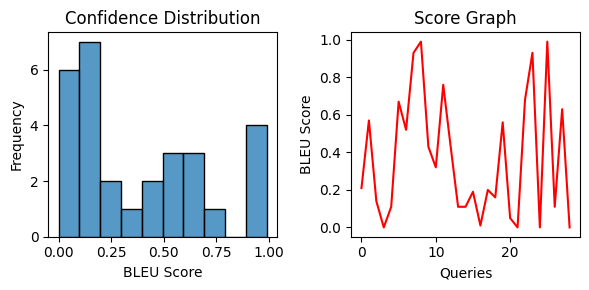

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

bleu_scores = validation['bleu_score']
num_bins = 10
fig, axes = plt.subplots(1, 2, figsize=(6,3))

sns.histplot(bleu_scores, bins=num_bins, ax=axes[0], kde=False)
axes[0].set_xlabel('BLEU Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Confidence Distribution')

example_indices = range(len(bleu_scores))
sns.lineplot(x=example_indices, y=bleu_scores, ax=axes[1], color='r')
axes[1].set_xlabel('Queries')
axes[1].set_ylabel('BLEU Score')
axes[1].set_title('Score Graph')

plt.tight_layout()

plt.show()
